# Solar Panel Graphics and Seaborn

## Introduction

In a previous blog post (https://coolum001.github.io/solar2.html), I had a graphic relating estimated solar radation received by my solar panels, and the energy generated.  It was produced by a quick-and-dirty call to top level matplotlib ```plot``` call, and I thought that I would improve the graphic by using Seaborn.

I learnt a lot about Seaborn.

--------------------
## Environment

Import packages and libraries we need.

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

import seaborn as sns


import pathlib

In [7]:
%load_ext watermark

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark


In [8]:
%load_ext lab_black

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


-----------------------
## Solar radiation data  load and explorationa 

I specified ```logpaddock``` grid point nearest to me (a distance of under 1K shouldn't make much difference to solar radiation), and downloaded a CSV file.

In [9]:
data_dir = pathlib.Path('../data/')

file1 = 'LongPaddockSolar.csv'

data_path = data_dir / file1

Read the CSV file into pandas.

In [10]:
solar = pd.read_csv(
    data_path,
    header=0,
    usecols=[2, 4],
    parse_dates={'PDate': [0]},
    dayfirst=True,
)

We note that one of the column names has a pesky trailing space, so get rid of it.

In [11]:
solar.rename(
    columns={'Solar ': 'Solar'},
    inplace=True,
)

-------------------------------------
## Solar panels data load and exploration

In [12]:
def read_year_file(year: int):
    '''
    read_year_file: read the solar panel data in CSV format for the given year

    We construct a file name from the supplied year value and read the CSV data,
    skipping over row 0 (first row) as a header,
    and only using the first two columns, that first of which contains a date.
    The day number comes first (i.e. DD/MM/YYY, as opposed to MM/DD/YYYY)

    Parameters:
    year: int - the notional year of the data set to be loaded
    note - each 365 day data set spans two years, due the the way data download was
    done from the PVOutput website

    Returns:
    pandas dataframe

    Limitations:
    Does not check for file actually existing

    Does not check for successful pandas CSV read
    '''
    data_dir = pathlib.Path('../data/SolarDaily')
    file1 = 'PVOutput-COOLUMSUNSPOT-' + str(year) + '.csv'
    data_path = data_dir / file1

    df = pd.read_csv(
        data_path,
        header=0,
        usecols=[0, 1],
        parse_dates={'Date': [0]},
        dayfirst=True,
    )
    return df


# end read_year_file

Data load and visualization.

In [13]:
year_dfs = [
    read_year_file(year) for year in range(2014, 2024, 1)
]

panels = pd.concat(year_dfs)
panels.sort_values(
    'Date',
    inplace=True,
)

Let's get the date range covered by my panels dataset.

In [14]:
panels.sort_values(by='Date', inplace=True)
panels = panels.reset_index().drop(columns=['index'])

---------------------
Now we create an integer index for the Solar Radiation dataframe, sorted by date.

In [15]:
solar.sort_values(
    by='PDate',
    inplace=True,
)
solar.reset_index().drop(columns=['index'])

,PDate,Solar
0,2015-01-01,28.5
1,2015-01-02,22.6
2,2015-01-03,10.7
3,2015-01-04,29.9
4,2015-01-05,18.7
...,...,...
3318,2024-02-01,20.7
3319,2024-02-02,29.4
3320,2024-02-03,29.1
3321,2024-02-04,23.4


-----------------------------------
## Visualize two datasets

We plot the Solar Radiation for each day, against the Panel energy generation.  This is the original graphic.

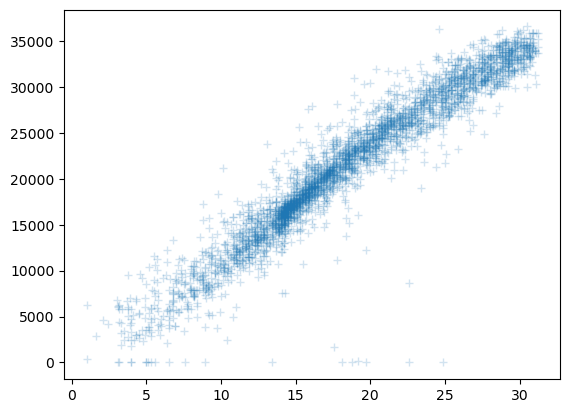

In [16]:
plt.plot(
    solar.iloc[
        0:3264,
    ]['Solar'],
    panels.iloc[
        234:,
    ]['GENERATED'],
    marker='+',
    linewidth=0,
    alpha=0.2,
)

---------------------------------
## Visualizing with Seaborn

To visualize the joint distibution of solar radiation and panel generation, we start by making a dict that has the lists of value suitably labelled.

In [17]:
sns_dict = {
    'Solar': list(
        solar.iloc[
            0:3264,
        ]['Solar']
    ),
    'Panels': list(
        panels.iloc[
            234:,
        ]['GENERATED']
    ),
}

Then we create a pandas DataFrame from the dict.

In [18]:
sns_df = pd.DataFrame(sns_dict)

In [19]:
sns_df.head(1)

,Solar,Panels
0,28.5,34445


Then we ask for a joint plot (a standard Seaborn style of graphic).

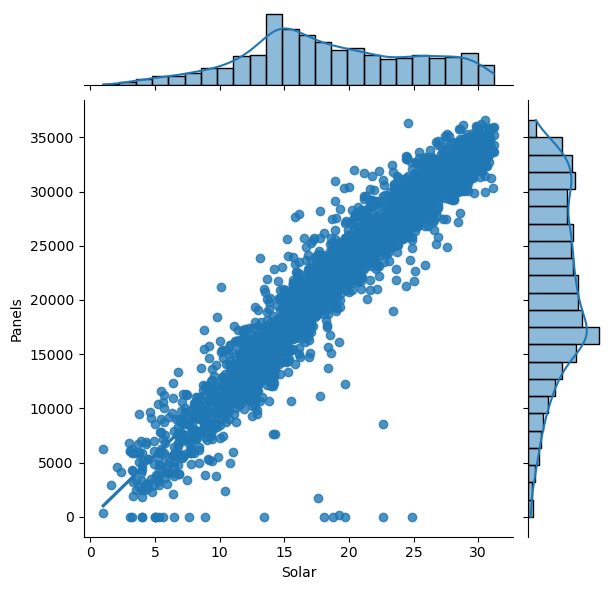

In [20]:
g = sns.jointplot(
    x='Solar',
    y='Panels',
    data=sns_df,
    kind='reg',
)

---------------------------------
## Iterative  improvement

### Fix the marker synbol
Aargh! My eyes!  What a horrible plot.  Let us see how to improve it.  The 3,000 and more data points overlap to hide the true structure of scatter plot, so we fix that first.

First, move to having the '+' as a marker.

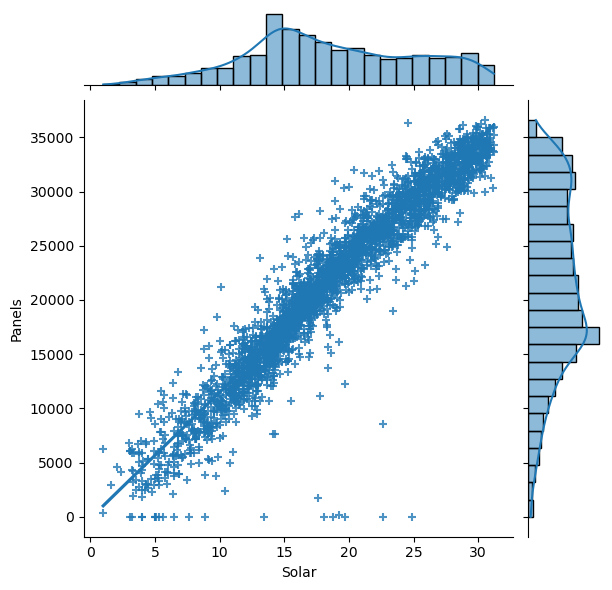

In [21]:
g = sns.jointplot(
    x='Solar',
    y='Panels',
    data=sns_df,
    kind='reg',
    marker='+',
)

Better, but the points are too thickly overlapped.  We set the ```alpha``` to make these markers more translucent.

Note the first little wrinkle in using Seaborn.  To change the marker symbol for one days radition / energy generation, we set a top level parameter (```marker```).  But to set the ```alpha``` for that very same symbol, we have to pass a parameter via the ```joint_kws``` parameter, by creating a dict, that has a keyword ```scatter_kws``` that maps to another dict, that tells the scatter plot generation call the parameter ```alpha=0.2``` we want be executed.



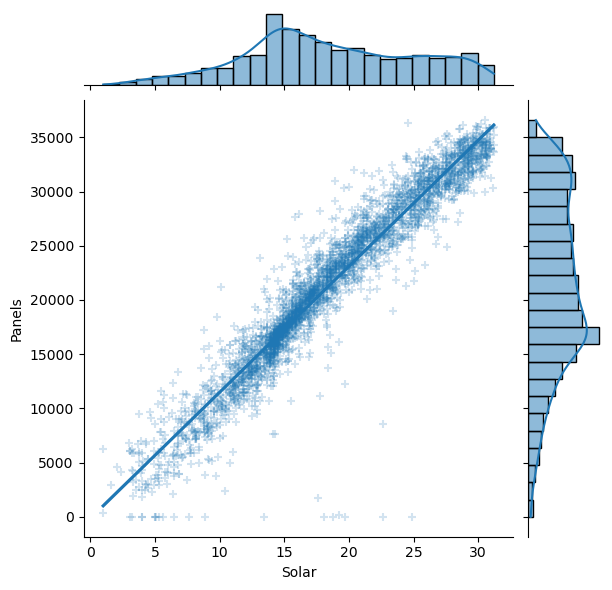

In [22]:
g = sns.jointplot(
    x='Solar',
    y='Panels',
    data=sns_df,
    kind='reg',
    marker='+',
    joint_kws={
        'scatter_kws': dict(alpha=0.2),
    },
)

This is better: the perceived visual density of the scattterplot markers now matches the X and Y distribution histograms.  The line of best fit is still hidden, so set that to a different color.

We can still see the days when there was no energy generated (solar panel failure after very violent storm blew water into connection sockets, panels removed to get a new roof, etc).

### Fix the line of best fit
Again we use the doubly nested dicts that deliver our parameter to the right mathod call.  How do we know that the key "scatter_kws" delivers parameters to the scatter plot call, but "line_kws" delivers para,meters to the call that draws the line of best fit?  We Google it, and get StackOverflow!

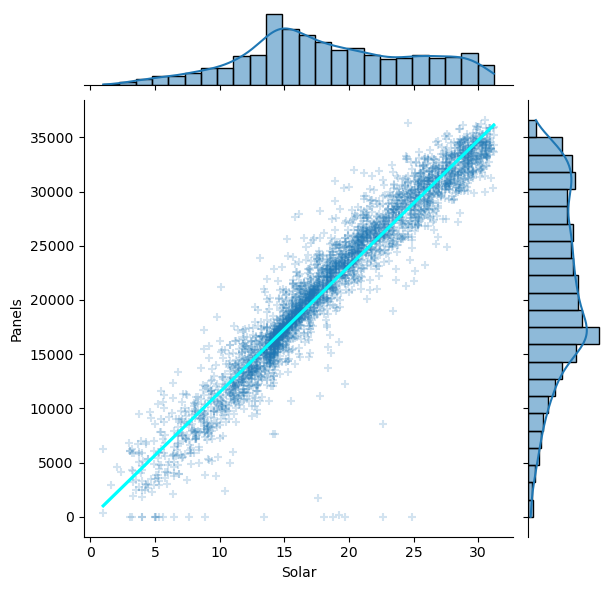

In [23]:
g = sns.jointplot(
    x='Solar',
    y='Panels',
    data=sns_df,
    kind='reg',
    marker='+',
    joint_kws={
        'scatter_kws': dict(alpha=0.2),
        'line_kws': {
            'color': 'cyan',
        },
    },
)

If we were expecting error bars (or shading) to show the Confidence Limits of the line of best fit, well, having over 3,000 points means we are very confident there is a linear relationship between our two variables.  If we show the first 50 points, we get the error bands we might have been expecting.

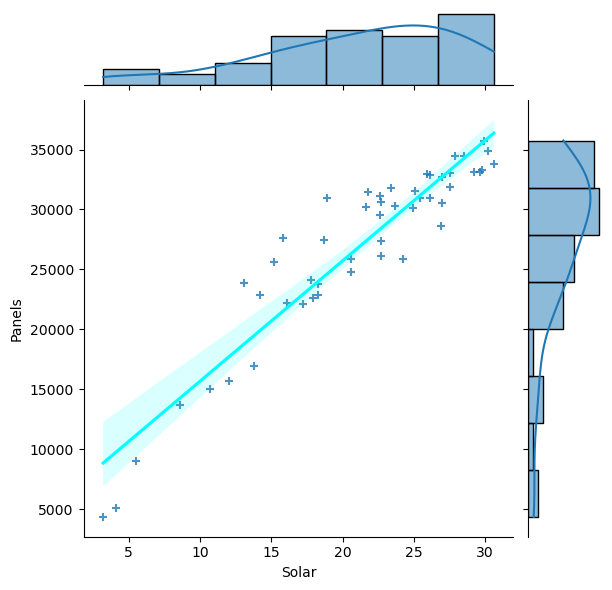

In [24]:
g = sns.jointplot(
    x='Solar',
    y='Panels',
    data=sns_df.iloc[0:50, :],
    kind='reg',
    marker='+',
    joint_kws={
        'scatter_kws': dict(alpha=0.8),
        'line_kws': {
            'color': 'cyan',
        },
    },
)

-------------------
### Marginal histograms
Now, let us fix the joint distribution histograms.  I don't like the fill of the bars, as it draws the eye from the central graphic.

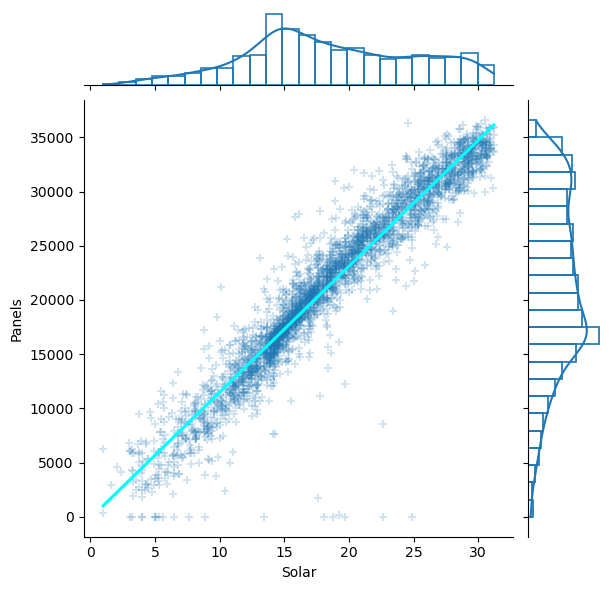

In [25]:
g = sns.jointplot(
    x='Solar',
    y='Panels',
    data=sns_df,
    kind='reg',
    marker='+',
    joint_kws={
        'scatter_kws': dict(alpha=0.2),
        'line_kws': {
            'color': 'cyan',
        },
    },
    marginal_kws=dict(
        fill=False,
    ),
)

Now the line on the histograms, showing the estimated density function, is something I don't need.

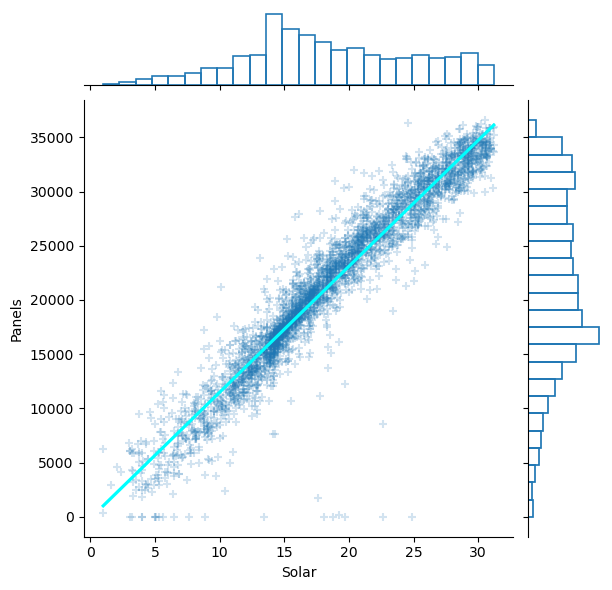

In [26]:
g = sns.jointplot(
    x='Solar',
    y='Panels',
    data=sns_df,
    kind='reg',
    marker='+',
    joint_kws={
        'scatter_kws': dict(alpha=0.2),
        'line_kws': {
            'color': 'cyan',
        },
    },
    marginal_kws=dict(
        fill=False,
        kde=False,
    ),
)

Now, increase the number of bins in the histograms, so see more of the fine structure of sunny and cloudy days.

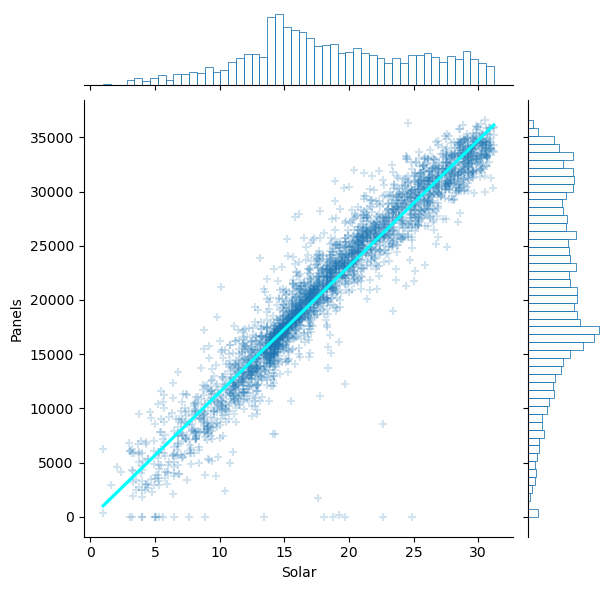

In [27]:
g = sns.jointplot(
    x='Solar',
    y='Panels',
    data=sns_df,
    kind='reg',
    marker='+',
    joint_kws={
        'scatter_kws': dict(alpha=0.2),
        'line_kws': {
            'color': 'cyan',
        },
    },
    marginal_kws=dict(
        bins=50,
        fill=False,
        kde=False,
    ),
)

-------------------
## Finishing touches

Drawing a legend was a tad harder than I expected.  First of all, adding a ```label=``` parameter to the scatter plot dict did not (as I had hoped) create a legend entry for the point markers.  However, adding a ```label``` parameter to the dict that is used into the draw line method, **did** create a legend entry.

What to do:  

* First, create an line that represents our marker, with same marker symbol, same marker color, etc, with line color white show only the symbol shows in the legend.  It has the label we wish to show in our legend.  This line is zero length.

* Then get the legend Seaborn created, and add it as an Artist to the Axes object that holds the scatter plot.

* Then create a legend from our zero length line, that overrides the Seaborn legend (good thing we added it as an independent Artist)

Finally, add some labels to the X and Y axis.

Text(87.59722222222221, 0.5, 'Panel Generation Wh')

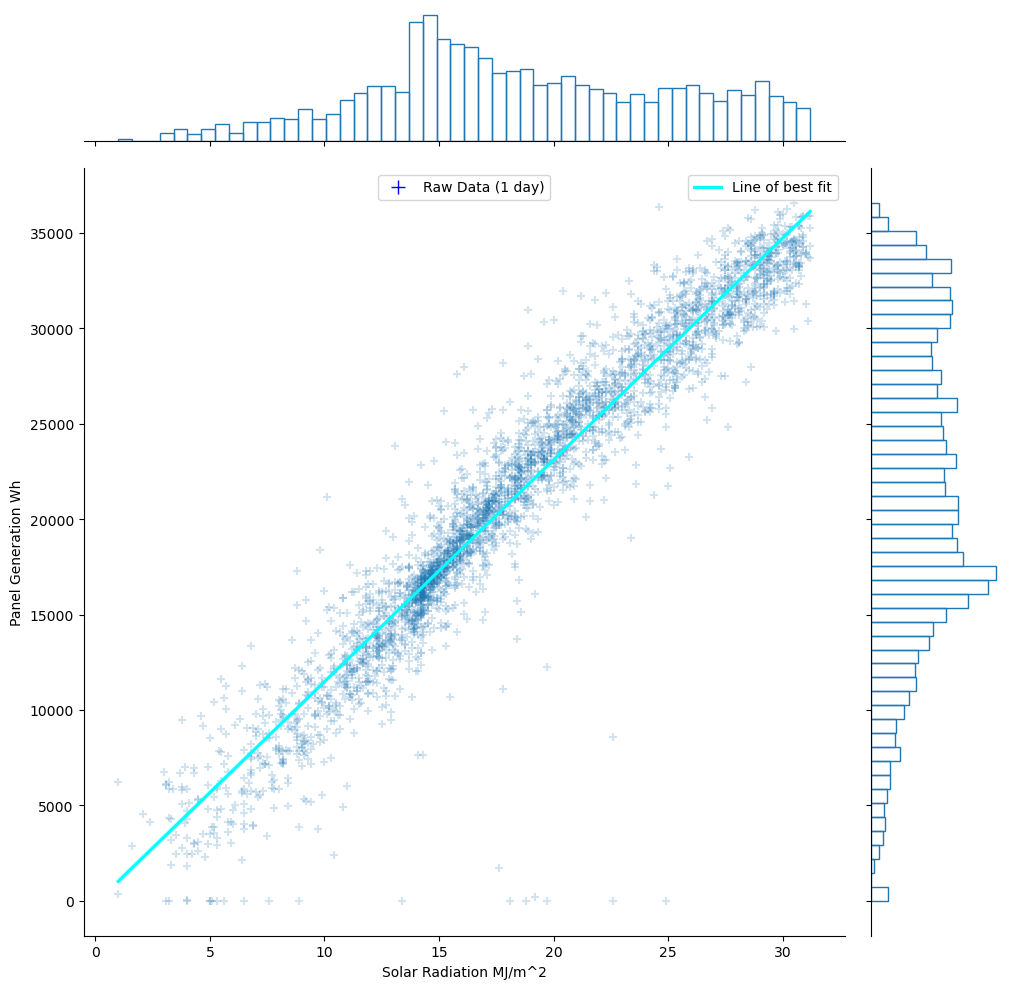

In [28]:
g = sns.jointplot(
    x='Solar',
    y='Panels',
    data=sns_df,
    kind='reg',
    marker='+',
    height=10,
    joint_kws={
        'scatter_kws': dict(
            alpha=0.2, label="Observed data"
        ),
        'line_kws': {
            'color': 'cyan',
            'label': 'Line of best fit',
        },
    },
    marginal_kws=dict(
        bins=50,
        fill=False,
        kde=False,
    ),
)

ax = g.ax_joint

raw_data_points = [
    Line2D(
        [],
        [],
        color='white',
        marker='+',
        markerfacecolor='blue',
        markeredgecolor='blue',
        markersize=10,
        label='Raw Data (1 day)',
    )
]

leg1 = ax.legend()

ax.add_artist(leg1)

ax.legend(
    handles=raw_data_points,
    loc='upper center',
)

ax.set_xlabel('Solar Radiation MJ/m^2')
ax.set_ylabel('Panel Generation Wh')

----------------------
## Reproducibility

In [29]:
%watermark

Last updated: 2024-03-04T14:22:21.117746+10:00

Python implementation: CPython
Python version       : 3.9.13
IPython version      : 7.31.1

Compiler    : MSC v.1916 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 94 Stepping 3, GenuineIntel
CPU cores   : 8
Architecture: 64bit



In [30]:
%watermark -co

conda environment: base



In [31]:
%watermark -iv

pathlib   : 1.0.1
pandas    : 1.4.4
matplotlib: 3.5.2
seaborn   : 0.11.2

